In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
evaluate_dogs_vs_cats_test.py
=============================
Evaluates the fine-tuned VGG19 model on the Dogs vs Cats test dataset.

Outputs:
1. submission.csv  →  Predicted labels for each test image
2. Confusion matrix
3. Classification metrics
4. Visualization of correctly and incorrectly classified samples
"""

import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import shutil



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cpu


In [3]:
# ==== DIRECTORIES ====

SCRATCH_DIR = "/Users/karthik/Desktop/AIDM_Project"
OUTPUT_DIR = "/Users/karthik/Desktop/AIDM_Project"
MODEL_PATH = os.path.join(OUTPUT_DIR, "best_vgg19.pth")
TEST_DIR = os.path.join(OUTPUT_DIR, "test_separated")

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 2
LABELS = {0: "cat", 1: "dog"}



In [4]:
# ==== DATA TRANSFORM ====
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ==== LOAD TEST DATA ====
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Loaded test dataset with {len(test_data)} images.")
class_names = test_data.classes  # ['cat', 'dog']


Loaded test dataset with 500 images.


In [5]:
# ==== MODEL SETUP ====
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ==== LOAD TRAINED WEIGHTS ====
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model checkpoint not found at {MODEL_PATH}")

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"Loaded trained model weights from: {MODEL_PATH}")



Loaded trained model weights from: /Users/karthik/Desktop/AIDM_Project/best_vgg19.pth


In [ ]:
# ==== PREDICTION AND EVALUATION ====
criterion = nn.CrossEntropyLoss()
test_loss, correct, total = 0.0, 0, 0
all_preds, all_labels, all_paths = [], [], []

print("\nEvaluating on test dataset...")

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



Evaluating on test dataset...


/Users/karthik/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [7]:
# ==== CALCULATE METRICS ====
test_loss /= total
test_acc = correct / total
print(f"\n==== TEST RESULTS ====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


==== TEST RESULTS ====
Test Loss: 0.0268
Test Accuracy: 98.80%


In [8]:
# ==== SAVE SUBMISSION FILE ====
image_files = []
for path, _ in test_data.imgs:
    image_files.append(os.path.basename(path))

submission = pd.DataFrame({
    "id": image_files,
    "label": all_preds  # 1 = dog, 0 = cat
})
submission.to_csv(os.path.join(OUTPUT_DIR, "submission_vgg19.csv"), index=False)
print(f"Submission file saved to: {os.path.join(OUTPUT_DIR, 'submission_vgg19.csv')}")


Submission file saved to: /Users/karthik/Desktop/AIDM_Project/submission_vgg19.csv


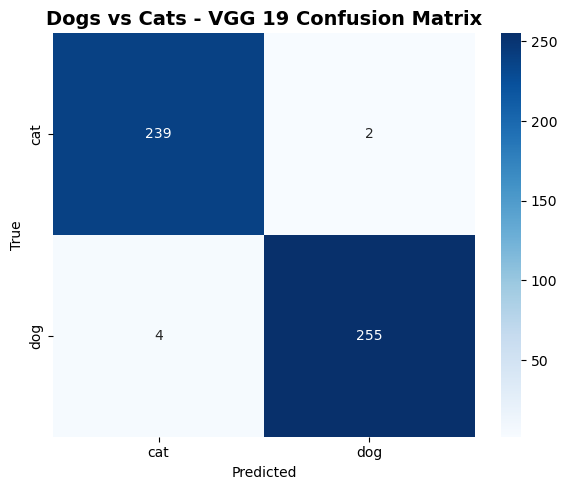

Confusion matrix saved to: /Users/karthik/Desktop/AIDM_Project/vgg19_confusion_matrix.png


In [11]:
# ==== CONFUSION MATRIX (MODIFIED - NOT NORMALIZED) ====
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.title("Dogs vs Cats - VGG 19 Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
cm_path = os.path.join(OUTPUT_DIR, "vgg19_confusion_matrix.png")
plt.savefig(cm_path, dpi=300)
plt.show()
print(f"Confusion matrix saved to: {cm_path}")


In [13]:
# ==== CLASSIFICATION REPORT ====
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(LABELS.values()), digits=3))

# ==== ORGANIZE PREDICTIONS INTO FOLDERS ====
print("\nOrganizing predictions into folders...")

# Create output directories
pred_cat_dir = os.path.join(OUTPUT_DIR, "predicted_cat")
pred_dog_dir = os.path.join(OUTPUT_DIR, "predicted_dog")
incorrect_dir = os.path.join(OUTPUT_DIR, "incorrect_predictions")

for dir_path in [pred_cat_dir, pred_dog_dir, incorrect_dir]:
    os.makedirs(dir_path, exist_ok=True)




Classification Report:
              precision    recall  f1-score   support

         cat      0.984     0.992     0.988       241
         dog      0.992     0.985     0.988       259

    accuracy                          0.988       500
   macro avg      0.988     0.988     0.988       500
weighted avg      0.988     0.988     0.988       500


Organizing predictions into folders...


In [14]:
# Get test dataset image paths and true labels
image_paths = [path for path, _ in test_data.imgs]
true_labels = [label for _, label in test_data.imgs]

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

correct_indices = np.where(all_labels == all_preds)[0]
incorrect_indices = np.where(all_labels != all_preds)[0]

print(f"Correctly classified samples: {len(correct_indices)}")
print(f"Incorrectly classified samples: {len(incorrect_indices)}")

# Copy images to respective folders based on predictions
for i, (img_path, true_label, pred_label) in enumerate(zip(image_paths, true_labels, all_preds)):
    img_filename = os.path.basename(img_path)
    
    if true_label == pred_label:
        # Correct prediction - copy to predicted category folder
        if pred_label == 0:  # cat
            shutil.copy2(img_path, os.path.join(pred_cat_dir, img_filename))
        else:  # dog
            shutil.copy2(img_path, os.path.join(pred_dog_dir, img_filename))
    else:
        # Incorrect prediction - copy to incorrect folder with info in filename
        true_class = LABELS[true_label]
        pred_class = LABELS[pred_label]
        new_filename = f"{true_class}_as_{pred_class}_{img_filename}"
        shutil.copy2(img_path, os.path.join(incorrect_dir, new_filename))

print(f"Images predicted as CAT copied to: {pred_cat_dir}")
print(f"Images predicted as DOG copied to: {pred_dog_dir}")
print(f"Incorrect predictions copied to: {incorrect_dir}")



Correctly classified samples: 494
Incorrectly classified samples: 6
Images predicted as CAT copied to: /Users/karthik/Desktop/AIDM_Project/predicted_cat
Images predicted as DOG copied to: /Users/karthik/Desktop/AIDM_Project/predicted_dog
Incorrect predictions copied to: /Users/karthik/Desktop/AIDM_Project/incorrect_predictions



Analyzing correct predictions...


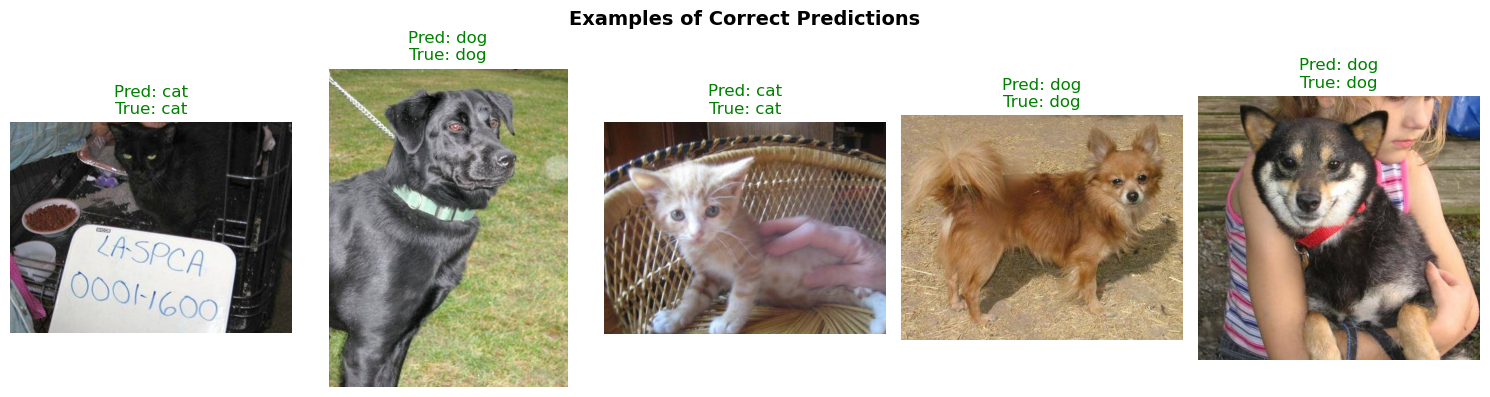

In [16]:
# ==== VISUALIZE CORRECT PREDICTIONS ====
print("\nAnalyzing correct predictions...")

# ---- Visualize Correct Samples ----
num_correct_show = min(5, len(correct_indices))
if num_correct_show > 0:
    fig, axes = plt.subplots(1, num_correct_show, figsize=(15, 4))
    if num_correct_show == 1:
        axes = [axes]
    
    for i, idx in enumerate(np.random.choice(correct_indices, num_correct_show, replace=False)):
        img = Image.open(image_paths[idx])
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {LABELS[all_preds[idx]]}\nTrue: {LABELS[all_labels[idx]]}", color='green')
        axes[i].axis('off')
    plt.suptitle("Examples of Correct Predictions", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No correct predictions to display!")


Analyzing incorrect predictions...


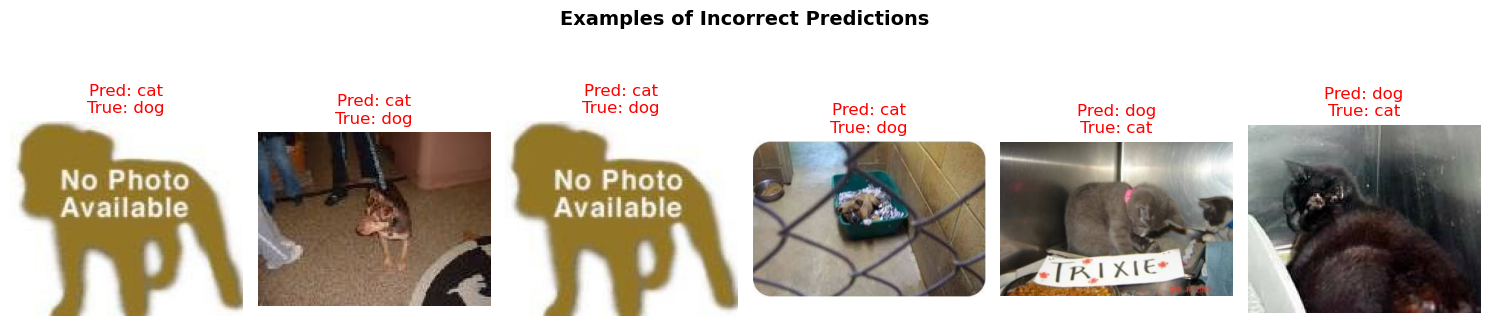

In [20]:
# ==== VISUALIZE INCORRECT PREDICTIONS ====
print("\nAnalyzing incorrect predictions...")

# ---- Visualize Incorrect Samples ----
num_incorrect_show = min(10, len(incorrect_indices))
if num_incorrect_show > 0:
    fig, axes = plt.subplots(1, num_incorrect_show, figsize=(15, 4))
    if num_incorrect_show == 1:
        axes = [axes]
    
    for i, idx in enumerate(np.random.choice(incorrect_indices, num_incorrect_show, replace=False)):
        img = Image.open(image_paths[idx])
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {LABELS[all_preds[idx]]}\nTrue: {LABELS[all_labels[idx]]}", color='red')
        axes[i].axis('off')
    plt.suptitle("Examples of Incorrect Predictions", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No incorrect predictions to display!")
